***EEG dataset of individuals with intellectual and developmental disorder and healthy controls while observing rest stimulus***

Dataset : https://data.mendeley.com/datasets/fshy54ypyh/1



*This data presents a collection of EEG recordings of seven participants with Intellectual and Developmental Disorder (IDD) and seven Typically Developing Controls (TDC). The data is recorded while the participants observe a resting state and a soothing musical stimulus. The data was collected using a high-resolution multi-channel dry-electrode system from EMOTIV called EPOC+. This is a 14-channel device with two reference channels and a sampling frequency of 128 Hz. The data was collected in a noise-isolated room. The participants were informed of the experimental procedure, related risks and were asked to keep their eyes closed throughout the experiment. The data is provided in two formats, (1) Raw EEG data and (2) Pre-processed and clean EEG data for both the group of participants. This data can be used to explore the functional brain connectivity of the IDD group. In addition, behavioral information like IQ, SQ, music apprehension and facial expressions (emotion) for IDD participants is provided in file “QualitativeData.xlsx".*


**Intellectual and developmental disorders (IDDs)** are a group of conditions that affect a person's ability to think, learn, and develop skills at the same pace as their peers.

What They Are: IDDs are conditions that cause significant limitations in intellectual functioning (such as reasoning, learning, and problem-solving) and in adaptive behavior (such as social and practical skills).
When They Occur: These disorders typically begin during the developmental period, which is before the age of 18.

**Typically developing controls (TDCs)** refers to individuals, usually children, who are developing normally without any diagnosed intellectual, developmental, or psychological disorders. These individuals are often used as a comparison group in research studies to understand the differences between those with specific conditions and those without.

What They Are: TDCs are individuals, often children, who show normal development in terms of cognitive, social, and physical milestones.

Purpose in Research: They serve as a baseline or standard to compare against individuals with developmental disorders or other conditions.


**Importing Required Libraries**

In [2]:
%%capture
!pip install mne

In [3]:
%%capture
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [4]:
# NumPy: Fundamental package for scientific computing with Python.
# Used for handling and manipulating data arrays.
import numpy as np

# SciPy: Library for scientific and technical computing.
# scipy.io is used to read MATLAB files into Python.
import scipy.io

# PyTorch: Open-source machine learning library for deep learning applications.
# torch and torch.nn are imported but not directly used in the provided code.
import torch
import torch.nn as nn

# Glob: Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
# Used to search for all .mat files in the specified directories.
from glob import glob

# MNE: Package for processing and analyzing electrophysiological data, such as EEG and MEG.
# Used for handling EEG data, creating MNE objects, setting up channel information, references, and filters, and creating epochs from continuous EEG data.
import mne

# Scikit-learn: Machine learning library for Python.
# Includes tools for data mining and data analysis.
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator

# TensorFlow/Keras: End-to-end open-source platform for machine learning with an API to simplify the creation of deep learning models.
# Used to build the neural network model, including convolutional layers, GRU layers, and dense layers.
from tensorflow.keras.layers import Input, Dense, concatenate, Flatten, GRU, Conv1D
from tensorflow.keras.models import Model


**Downloading and Unzipping the Dataset**


In [5]:
!pip install mne
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip -O data.zip
!unzip data.zip

--2024-08-03 15:24:17--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/fshy54ypyh-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.30.240, 52.92.20.170, 3.5.66.193, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.30.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34238119 (33M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  32.65M  13.4MB/s    in 2.4s    

2024-08-03 15:24:21 (13.4 MB/s) - ‘data.zip’ saved [34238119/34238119]

Archive:  data.zip
  inflating: EEG dataset of individuals with intellectual and developmental disorder and healthy controls while observing rest and musical stimulus/Data/_DS_Store  
  inflating: EEG dataset of individuals with intellectual and developmental disorder and heal

**Loading and Preprocessing Data**

In [6]:
IDD = '/content/EEG dataset of individuals with intellectual and developmental disorder and healthy controls while observing rest and musical stimulus/Data/CleanData/CleanData_IDD/Rest'
TDC = '/content/EEG dataset of individuals with intellectual and developmental disorder and healthy controls while observing rest and musical stimulus/Data/CleanData/CleanData_TDC/Rest'
!rm '/content/EEG dataset of individuals with intellectual and developmental disorder and healthy controls while observing rest and musical stimulus/Data/CleanData/CleanData_IDD/Rest/NDS001_Rest_CD(1).mat'

**Convert .mat Files to MNE Format**

**Channel Names and Types:**
ch_names lists the names of the EEG channels.
ch_types sets the type for each channel, all being 'eeg'.

**Sampling Frequency:**
sampling_freq is set to 128 Hz, which is the rate at which the EEG data was sampled.

**Info Object:**
mne.create_info creates an info object with metadata about the EEG channels.

**Montage:**
info.set_montage('standard_1020') sets the standard 10-20 system montage, which defines the spatial layout of EEG electrodes.

**RawArray Object:**
mne.io.RawArray(data, info) creates a RawArray object that holds the EEG data along with the metadata.

**EEG Reference:**
data.set_eeg_reference() re-references the EEG data to a common reference.

**Bandpass Filter:**
data.filter(l_freq=1, h_freq=30) applies a bandpass filter to keep only the frequencies between 1 and 30 Hz.

**Epoching:**
mne.make_fixed_length_epochs(data, duration=4, overlap=0) segments the continuous EEG data into epochs of 4 seconds each without overlap.

**Return Data:**
epochs.get_data() extracts the data from the epochs and returns it as a NumPy array.

In [7]:
def convertmat2mne(data):
    # Define channel names as per the standard 10-20 EEG system.
    ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

    # Define channel types; all channels are EEG channels in this case.
    ch_types = ['eeg'] * 14

    # Define the sampling frequency of the EEG data.
    sampling_freq = 128

    # Create an MNE info object which holds metadata about the channels.
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)

    # Set the standard 10-20 system montage (spatial layout of the electrodes).
    info.set_montage('standard_1020')

    # Create an MNE RawArray object from the data and the info object.
    data = mne.io.RawArray(data, info)

    # Set the EEG reference. This step re-references the EEG data.
    data.set_eeg_reference()

    # Apply a bandpass filter to the data, keeping frequencies between 1 and 30 Hz.
    data.filter(l_freq=1, h_freq=30)

    # Create fixed-length epochs (segments) of 4 seconds from the continuous EEG data, with no overlap.
    epochs = mne.make_fixed_length_epochs(data, duration=4, overlap=0)

    # Return the data from the epochs as a NumPy array.
    return epochs.get_data()


**Loading Data and Applying Conversion**

In [8]:
# Initialize an empty list to store the processed EEG data for individuals with intellectual and developmental disorder (IDD).
idd_subject = []

# Use glob to find all .mat files in the IDD directory.
for idd in glob(IDD + '/*.mat'):
    # Load the .mat file using scipy.io.loadmat. The data is assumed to be under the key 'clean_data'.
    data = scipy.io.loadmat(idd)['clean_data']

    # Convert the loaded MATLAB data to MNE format and preprocess it.
    data = convertmat2mne(data)

    # Append the processed data to the idd_subject list.
    idd_subject.append(data)

# Initialize an empty list to store the processed EEG data for typically developing controls (TDC).
tdc_subject = []

# Use glob to find all .mat files in the TDC directory.
for tdc in glob(TDC + '/*.mat'):
    # Load the .mat file using scipy.io.loadmat. The data is assumed to be under the key 'clean_data'.
    data = scipy.io.loadmat(tdc)['clean_data']

    # Convert the loaded MATLAB data to MNE format and preprocess it.
    data = convertmat2mne(data)

    # Append the processed data to the tdc_subject list.
    tdc_subject.append(data)


Creating RawArray with float64 data, n_channels=14, n_times=15360
    Range : 0 ... 15359 =      0.000 ...   119.992 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 423 samples (3.305 s)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 512 original time points ...
0 bad epochs drop

**Labeling the Data**

In [9]:
control_epochs_labels = [len(i) * [0] for i in tdc_subject]
patients_epochs_labels = [len(i) * [1] for i in idd_subject]

**Combining Data and Labels**

In [10]:
# Concatenate the processed EEG data from TDC and IDD subjects into a single list.
data_list = tdc_subject + idd_subject

# Concatenate the labels for control (TDC) and patient (IDD) epochs into a single list.
label_list = control_epochs_labels + patients_epochs_labels

# Create a list indicating the group (subject) each epoch belongs to. This helps in cross-validation.
# For each subject's data in data_list, create a list of the same length with the index of that subject.
groups_list = [[i] * len(j) for i, j in enumerate(data_list)]

# Convert the list of data arrays into a single NumPy array.
# This involves stacking the arrays along a new axis.
data_array = np.concatenate(data_list)

# Convert the list of labels into a single NumPy array.
label_array = np.concatenate(label_list)

# Convert the list of groups into a single NumPy array.
group_array = np.concatenate(groups_list)

# Move the axis of the data array from (epochs, channels, time points) to (epochs, time points, channels).
# This reshaping is necessary for input into certain machine learning models, like convolutional neural networks.
data_array = np.moveaxis(data_array, 1, 2)

# Let's print the shapes of these arrays to understand their structure.
print("Data array shape:", data_array.shape)
print("Label array shape:", label_array.shape)
print("Group array shape:", group_array.shape)


Data array shape: (420, 512, 14)
Label array shape: (420,)
Group array shape: (420,)


**Scaling the Data**

In [11]:
# Import necessary base classes from scikit-learn for creating custom transformers.
from sklearn.base import BaseEstimator, TransformerMixin
# Import the StandardScaler class from scikit-learn for standardizing data.
from sklearn.preprocessing import StandardScaler

# Define a custom transformer class StandardScaler3D for standardizing 3D data arrays.
class StandardScaler3D(BaseEstimator, TransformerMixin):

    # Initialize the StandardScaler3D instance.
    def __init__(self):
        # Create an instance of the StandardScaler class.
        self.scaler = StandardScaler()

    # Fit the scaler on the data.
    # X is expected to be a 3D array: (samples, time points, channels).
    def fit(self, X, y=None):
        # Reshape the data to 2D: (samples * time points, channels).
        # This is because StandardScaler expects 2D input (n_samples, n_features).
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    # Transform the data using the fitted scaler.
    def transform(self, X):
        # Reshape the data to 2D: (samples * time points, channels).
        # Apply the scaler to the reshaped data.
        # Reshape the data back to its original 3D shape after scaling.
        return self.scaler.transform(X.reshape(-1, X.shape[2])).reshape(X.shape)


**Model Training and Validation**

In [12]:
# Import GroupKFold for group-wise cross-validation.
from sklearn.model_selection import GroupKFold

# Initialize GroupKFold for splitting the data while preserving group information.
gkf = GroupKFold()

# Iterate over the train/validation indices provided by GroupKFold.
for train_index, val_index in gkf.split(data_array, label_array, groups=group_array):
    # Split the data into training and validation sets using the provided indices.
    train_features, train_labels = data_array[train_index], label_array[train_index]
    val_features, val_labels = data_array[val_index], label_array[val_index]

    # Initialize the custom StandardScaler3D to scale the features.
    scaler = StandardScaler3D()

    # Fit the scaler on the training features and transform them.
    train_features = scaler.fit_transform(train_features)

    # Transform the validation features using the fitted scaler.
    val_features = scaler.transform(val_features)

    # Define the input layer for the neural network. The shape is (512, 14), corresponding to the time points and channels.
    input_layer = Input(shape=(512, 14))

    # Define a function to create a block of Conv1D layers with different kernel sizes.
    def block(input):
        conv1 = Conv1D(32, 2, strides=2, activation='relu', padding="same")(input)
        conv2 = Conv1D(32, 4, strides=2, activation='relu', padding="causal")(input)
        conv3 = Conv1D(32, 8, strides=2, activation='relu', padding="causal")(input)
        return concatenate([conv1, conv2, conv3], axis=2)

    # Create three blocks of Conv1D layers.
    block1 = block(input_layer)
    block2 = block(block1)
    block3 = block(block2)

    # Add GRU layers with the specified number of units and activation function.
    gru_out1 = GRU(32, activation='tanh', return_sequences=True)(block3)
    gru_out2 = GRU(32, activation='tanh', return_sequences=True)(gru_out1)

    # Concatenate the outputs of the GRU layers.
    gru_out = concatenate([gru_out1, gru_out2], axis=2)

    # Add another GRU layer and concatenate its output with previous GRU outputs.
    gru_out3 = GRU(32, activation='tanh', return_sequences=True)(gru_out)
    gru_out = concatenate([gru_out1, gru_out2, gru_out3])

    # Add a final GRU layer without return_sequences, so it outputs only the last time step.
    gru_out4 = GRU(32, activation='tanh')(gru_out)

    # Add a Dense layer with a sigmoid activation function to produce the final prediction.
    predictions = Dense(1, activation='sigmoid')(gru_out4)

    # Create the model by specifying the input and output layers.
    model = Model(inputs=input_layer, outputs=predictions)

    # Compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric.
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model on the training data, validating on the validation data.
    # Store the training history in the `history` variable.
    history = model.fit(train_features, train_labels, epochs=10, batch_size=128, validation_data=(val_features, val_labels))

    # Exit the loop after the first fold.
    break


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 913ms/step - accuracy: 0.4848 - loss: 0.6940 - val_accuracy: 0.3333 - val_loss: 0.7430
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - accuracy: 0.5276 - loss: 0.6572 - val_accuracy: 0.4222 - val_loss: 0.6516
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.7839 - loss: 0.5644 - val_accuracy: 0.9444 - val_loss: 0.4744
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 678ms/step - accuracy: 0.9644 - loss: 0.4284 - val_accuracy: 0.9667 - val_loss: 0.3501
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.9866 - loss: 0.2451 - val_accuracy: 1.0000 - val_loss: 0.1472
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 433ms/step - accuracy: 1.0000 - loss: 0.0996 - val_accuracy: 1.0000 - val_loss: 0.0445
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 0.9975 - loss: 0.0363 - val_accuracy: 1.0000 - val_loss: 0.0233
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step - accuracy: 1.0000 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss

**Plotting Accuracy and Loss Graphs**

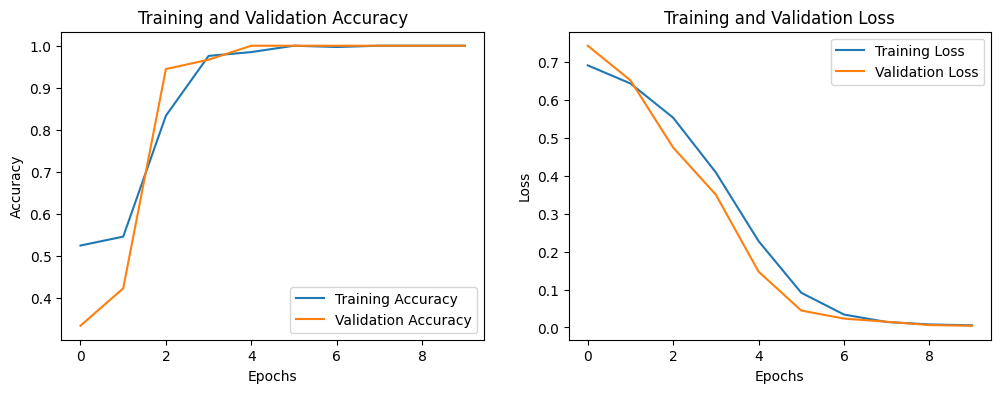

In [14]:
import matplotlib.pyplot as plt


# Plotting the training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
